In [4]:
import pandas as pd
import os
import gzip
from Bio.Seq import Seq
from Bio import SeqIO, bgzf
import itertools
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import yaml

sns.set_context('talk')


This notebook generates "simulated" titeseq data to test our pipelines before actually running it on the Titeseq data. It uses the NGS results from genewiz. Before running this you should copy the data from genewiz into the directory `Titeseq/data`.

# Read in metadata

In [2]:
sample_sheet = pd.read_table('metadata/sample_info.tsv', index_col=0)
sample_sheet.head()

,construct,replicate,concentration,bin,sample_name,P5,P7,OM_col_i,OM_row_i,cell count
sample_id,,,,,,,,,,
1,RBD,a,7,1.0,RBD_a_7_1,1,1,1,1,10005
2,RBD,a,7,2.0,RBD_a_7_2,1,2,1,2,331939
3,RBD,a,7,3.0,RBD_a_7_3,1,3,1,3,351138
4,RBD,a,7,4.0,RBD_a_7_4,1,4,1,4,324292
5,RBD,a,75,1.0,RBD_a_75_1,1,5,1,5,11225


In [11]:
config = yaml.safe_load(open('metadata/config.yaml'))
col_i = config['col_inline_indices']
row_i = config['row_inline_indices'] 

# Read existing data

We'll just use the existing NGS data from genewiz to generate fake data.

In [12]:
def fastq_to_df(filename, debug_limit=500000):
    reads = []
    num_reads = 0
    for read in SeqIO.parse(gzip.open(filename, 'rt'), 'fastq'):
        num_reads += 1
        if num_reads > debug_limit:
            break
        reads.append(str(read.seq))
    return pd.Series(reads)

read_1 = fastq_to_df('Titeseq/data/30-655666424/00_fastq/AM-OMI-LIB_R1_001.fastq.gz')
read_2 = fastq_to_df('Titeseq/data/30-655666424/00_fastq/AM-OMI-LIB_R2_001.fastq.gz')


 Attach on a random UMI and the correct row and col indices, maybe adding in some errors. then just save as fasta

In [13]:
def generate_UMIs(length, num):
    arr = np.random.choice(['A','C','G','T'], size=length*num)
    arr = arr.reshape((num, length))
    arr = [''.join(row) for row in arr]
    return arr

In [14]:
NUM_READS_PER_SAMPLE = 100
UMI_LENGTH = 8
n = NUM_READS_PER_SAMPLE

for sample_id in sample_sheet.index:
    read_1_subset = read_1[sample_id*n:(sample_id+1)*n]
    col_idx = col_i[sample_sheet['OM_col_i'][sample_id]-1]
    UMIs_1 = pd.Series(generate_UMIs(UMI_LENGTH, n), index=read_1_subset.index)
    read_2_subset = read_2[sample_id*n:(sample_id+1)*n]
    UMIs_2 = pd.Series(generate_UMIs(UMI_LENGTH, n), index=read_2_subset.index)
    row_idx = row_i[sample_sheet['OM_row_i'][sample_id]-1]
    
    read_1_modif = UMIs_1 + col_idx + read_1_subset    
    read_2_modif = UMIs_2 + row_idx + read_2_subset

    records_1 = [SeqIO.SeqRecord(Seq(seq), str(id), letter_annotations=dict(phred_quality=[40]*len(seq))) for (id,seq) in read_1_modif.iteritems()]
    records_2 = [SeqIO.SeqRecord(Seq(seq), str(id), letter_annotations=dict(phred_quality=[40]*len(seq))) for (id,seq) in read_2_modif.iteritems()]
    
    sample_name = sample_sheet['sample_name'][sample_id]
    with bgzf.BgzfWriter(f'data/simulated/{sample_name}_S{sample_id}_R1_001.fastq.gz', 'wb') as outgz:
        SeqIO.write(sequences=records_1, handle=outgz, format='fastq')
    with bgzf.BgzfWriter(f'data/simulated/{sample_name}_S{sample_id}_R2_001.fastq.gz', 'wb') as outgz:
        SeqIO.write(sequences=records_2, handle=outgz, format='fastq')

# Check where errors are...

The rest of this notebook is just to visualize where the sequencing errors are located. Run snakemake before this, as this uses the regexes generated by the pipeline

In [67]:
import regex
geno_for_regex = regex.compile(open('results/regexes/geno_for_regex.txt').read())
geno_rev_regex = regex.compile(open('results/regexes/geno_rev_regex.txt').read())

matches_1 = [geno_for_regex.match(s) for s in read_1]
matches_2 = [geno_rev_regex.match(s) for s in read_2]

matches = [(m1, m2) for (m1, m2) in zip(matches_1, matches_2)
           if m1 and m2]

In [68]:
print('num matched:', len(matches), sep='\t')
print('num reads:', len(read_1), sep='\t')

num matched:	82391
num reads:	288495


In [69]:
for_subs = []
rev_subs = []
for_indels = []
rev_indels = []
for m1,m2 in matches:
    for_subs.extend(m1.fuzzy_changes[0])
    rev_subs.extend(m2.fuzzy_changes[0])
    for_indels.extend(m1.fuzzy_changes[1])
    for_indels.extend(m1.fuzzy_changes[2])
    rev_indels.extend(m2.fuzzy_changes[1])
    rev_indels.extend(m2.fuzzy_changes[2])

site 118:	705
site 146:	417
site 111:	362
site 87:	324
site 2:	266
site 156:	232
site 136:	215
site 45:	206
site 121:	204
site 106:	199


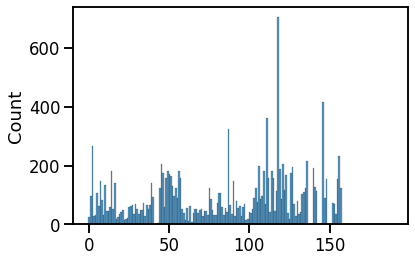

In [79]:
from collections import Counter
sns.histplot(for_subs, bins=np.arange(-0.5, 190.5))
for idx,counts in Counter(for_subs).most_common(10):
    print(f'site {idx}:\t{counts}')

site 211:	3282
site 190:	3074
site 219:	2388
site 220:	2350
site 184:	1718
site 210:	1714
site 189:	1656
site 193:	1152
site 197:	1024
site 156:	1020


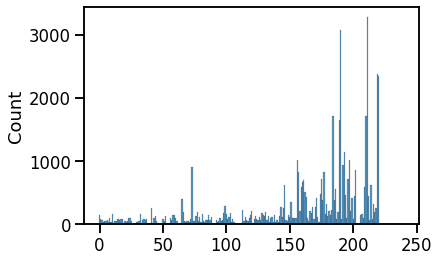

In [78]:
sns.histplot(rev_subs, bins=np.arange(-0.5, 240.5))
for idx,counts in Counter(rev_subs).most_common(10):
    print(f'site {idx}:\t{counts}')

In [72]:
for idx,counts in Counter(for_indels).most_common(10):
    print(f'site {idx}:\t{counts}')

site 1:	451
site 41:	29
site 2:	28
site 40:	4
site 37:	2
site 0:	2
site 8:	2
site 9:	1
site 3:	1
site 38:	1


In [73]:
for idx,counts in Counter(rev_indels).most_common(10):
    print(f'site {idx}:\t{counts}')

site 0:	830
site 1:	203
site 6:	133
site 2:	37
site 7:	10
site 12:	1
site 13:	1
site 10:	1
site 8:	1
site 16:	1


In [74]:
m2.group()

'GATAAAACCACAACTCTGTATGGCTGATGGCCAACTCCGTTTGTAGGCCTGAAAGAGTATGACTGTAGGGGGAAGTAACAGTTGAAGCCCTCGACGCCATTGCAGGGCTTGTTACCGGCCTGATATATCTCCGTGGAGATGTCCCTTTCGAACGGCTTCAAATTTGATTTCCTGAAAAGACGGTACAGGTAGTGATAATTTCCTCCCACCTTTGAGTCTAAGTT'

In [75]:
def rc(x):
    return str(Seq(x).reverse_complement())

rc(m2.group())

'AACTTAGACTCAAAGGTGGGAGGAAATTATCACTACCTGTACCGTCTTTTCAGGAAATCAAATTTGAAGCCGTTCGAAAGGGACATCTCCACGGAGATATATCAGGCCGGTAACAAGCCCTGCAATGGCGTCGAGGGCTTCAACTGTTACTTCCCCCTACAGTCATACTCTTTCAGGCCTACAAACGGAGTTGGCCATCAGCCATACAGAGTTGTGGTTTTATC'

In [76]:
m2.fuzzy_changes

([193], [], [])

In [77]:
len(m2.group())

224